# Library

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False

import matplotlib.pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

import random

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# Load Data

In [2]:
batch_size = 2048

fmnist_train = dset.FashionMNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
fmnist_test = dset.FashionMNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [3]:
class FC_Block(nn.Module) : 
    def __init__(self, input_dim, output_dim) : 
        super(FC_Block, self).__init__()

        self.linear = nn.Linear(input_dim, output_dim, bias = True)
        self.relu = nn.functional.relu
        self.batch_norm = nn.BatchNorm1d(output_dim)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x) : 
        x = self.linear(x)
        x = self.relu(x)
        x = self.batch_norm(x)
        x = self.dropout(x)
        return x

In [4]:
class VAE(nn.Module) : 
    def __init__(self) : 
        super(VAE,self).__init__()
        self.encoder = nn.Sequential(
            FC_Block(28*28, 256),
            FC_Block(256,64),
            FC_Block(64,32)
        )
        self.fc_mu = nn.Linear(32,10)
        self.fc_sigma = nn.Linear(32,10)
        self.decoder = nn.Sequential(
            FC_Block(10,32),
            FC_Block(32,64),
            FC_Block(64,256),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x) : 
        h = self.encoder(x)
        mu = self.fc_mu(h)
        sigma = self.fc_sigma(h)
        return mu, sigma

    def reparam(self, mu, sigma) : 
        std = torch.exp(0.5 * sigma)
        eps = torch.randn_like(std)

        return mu + std * eps
    
    def decode(self, x) : 
        reconstruction = self.decoder(x)
        return reconstruction

    def forward(self, x ) : 
        x = x.view(-1,28*28)
        mu, sigma= self.encode(x)
        z = self.reparam(mu, sigma)
        recons = self.decode(z)
        return recons, mu, sigma

In [5]:
def saveModel(path):
    torch.save(model.state_dict(), path)

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, early_stop, path) : 
    import time

    since = time.time()
    best_loss = 1e+5
    early_stop_epoch = 0
    

    for epoch in range(num_epochs) : 

        for phase in ['train','valid'] : 
            if phase == 'train' : 
                model.train()
            elif phase == 'valid' : 
                model.eval()

            running_loss = 0

            for x,_ in dataloaders[phase] : 
                x = x.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase =='train') : 
                    output, mu, sigma = model(x)
                    loss = criterion(x, output, mu, sigma)

                    if phase == 'train' : 
                        
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            if phase == 'valid' and epoch_loss < best_loss : 
                print(f'On Epoch {epoch}, Best Model Saved with Valid Loss {round(epoch_loss, 4)}')
                
                best_loss = epoch_loss
                saveModel(path)
                early_stop_epoch = 0
            elif phase == 'valid' : 
                early_stop_epoch += 1

        if early_stop_epoch >= early_stop : 
            "Early Stop Occured"
            break;
    time_elapsed = time.time() - since
    print(f'Training Complete in {time_elapsed//60}min {time_elapsed%60}sec')


    model.load_state_dict(torch.load(path))
    return model


In [7]:
def loss_fn(input, output, mu, log_var):
    BCE_loss = BCE(output, input.view(-1,28*28))
    KLD_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE_loss + KLD_loss

In [8]:
def return_dataloaders(train_idx, valid_idx) : 
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_idx)

    train_data = DataLoader(dataset=fmnist_train, batch_size = batch_size, sampler = train_subsampler)
    valid_data = DataLoader(dataset=fmnist_train, batch_size = batch_size, sampler = valid_subsampler)
    test_data  = DataLoader(dataset = fmnist_test, batch_size  = batch_size , shuffle = False)
    

    dataloaders = {}
    dataloaders['train'] = train_data
    dataloaders['valid'] = valid_data
    dataloaders['test'] = test_data
    return dataloaders

In [9]:
from sklearn.model_selection import StratifiedKFold

n_split = 5
skf = StratifiedKFold(n_splits = n_split, shuffle = True)
BCE = nn.BCELoss(reduction='sum')

In [10]:
trained_weights = []
for fold_num, (train_idx, valid_idx) in enumerate(skf.split(np.arange(fmnist_train.__len__()), fmnist_train.targets)) : 
    path = f'VAE_{fold_num}.pth'
    model = VAE().to(device)
    optimizer = optim.Adam(model.parameters(), lr = 1e-3)
    dataloader = return_dataloaders(train_idx, valid_idx)
    trained_model = train_model(model, dataloader, loss_fn, optimizer, 100, 5, path)
    trained_weights.append(path)
    break;

On Epoch 0, Best Model Saved with Valid Loss 102.712
On Epoch 1, Best Model Saved with Valid Loss 87.0366
On Epoch 2, Best Model Saved with Valid Loss 68.9334
On Epoch 3, Best Model Saved with Valid Loss 60.8048
On Epoch 4, Best Model Saved with Valid Loss 58.2337
On Epoch 5, Best Model Saved with Valid Loss 57.2476
On Epoch 6, Best Model Saved with Valid Loss 56.5279
On Epoch 7, Best Model Saved with Valid Loss 56.0547
On Epoch 8, Best Model Saved with Valid Loss 55.6402
On Epoch 9, Best Model Saved with Valid Loss 55.1538
On Epoch 10, Best Model Saved with Valid Loss 54.7257
On Epoch 11, Best Model Saved with Valid Loss 54.3664
On Epoch 12, Best Model Saved with Valid Loss 53.9746
On Epoch 13, Best Model Saved with Valid Loss 53.6624
On Epoch 14, Best Model Saved with Valid Loss 53.2954
On Epoch 15, Best Model Saved with Valid Loss 53.0786
On Epoch 16, Best Model Saved with Valid Loss 52.8538
On Epoch 17, Best Model Saved with Valid Loss 52.6364
On Epoch 18, Best Model Saved with Val

# Visualization

## Image Reconstruction

In [11]:
with torch.no_grad() : 
    running_loss = 0.0
    for x,_ in dataloader['test'] : 
        x = x.to(device)

        recon, mu, sigma = trained_model(x)
        test_loss = loss_fn(x, recon, mu, sigma)
        running_loss += test_loss.item()

    test_loss = running_loss / len(dataloader['test'].dataset)
    print(test_loss)

248.386490625


torch.Size([1808, 784])


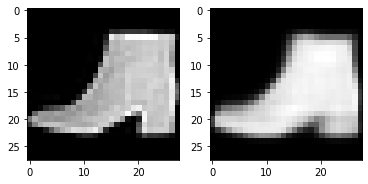

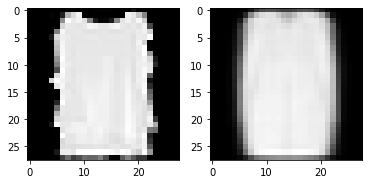

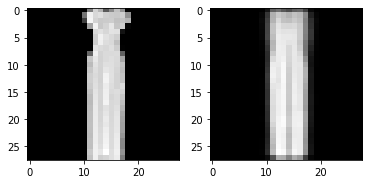

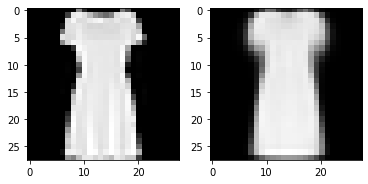

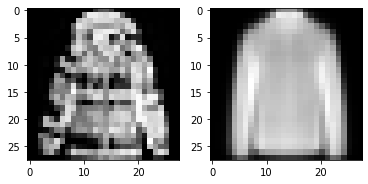

In [12]:
recon_img = torch.squeeze(recon.cpu().data)
print(recon_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(x[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(recon_img[i].numpy().reshape(28, 28),cmap='gray')
    plt.show()

## VAE의 특징 확인하기

- VAE는 데이터의 분포를 학습함
- 따라서, 두 서로 다른 이미지 사이의 분포를 가진 이미지는 두 이미지의 특징을 모두 가지고 있음

In [13]:
train_dataset_array = fmnist_train.data.numpy()
train_dataset_array = np.float32(train_dataset_array)
labels = fmnist_train.targets.numpy()

In [14]:
subset_indices = []
subset_indices_per_class = []

for i in range(10):
    indices = np.where(labels == i)[0]
    subset_size = len(indices) // 6
    subset_indices += indices[:subset_size].tolist()
    subset_indices_per_class.append(indices[:subset_size].tolist())

train_dataset_array = train_dataset_array[subset_indices]
labels = labels[subset_indices]

In [15]:
print(len(train_dataset_array))
train_dataset_array = torch.tensor(train_dataset_array)
inputs = train_dataset_array.to(device)
outputs, mu, log_var = trained_model(inputs)
encoded = mu.cpu().detach().numpy()

10000


In [16]:
mean_encoded = []
for i in range(10):
    mean_encoded.append(encoded[np.where(labels == i)[0]].mean(axis=0))

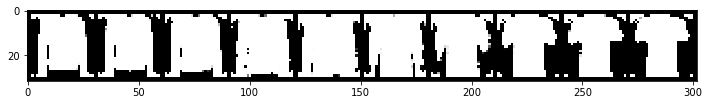

In [19]:
selected_class = [0, 2]
samples = []
with torch.no_grad():
    for idx, coef in enumerate(np.linspace(0, 1, 10)):
        interpolated = coef * mean_encoded[selected_class[0]] + (1.-coef) * mean_encoded[selected_class[1]]
        samples.append(interpolated)
    samples = np.stack(samples)
    z = torch.tensor(samples).to(device)
    generated = trained_model.decoder(z).cuda()
from torchvision.utils import make_grid
generated = generated.view(10, 1, 28, 28)
plt.figure(figsize = (12,10))
img = make_grid(generated, nrow=10)
npimg = img.cpu().numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
plt.show()